In [230]:
import networkx as nx
import random
import sympy as sp
import IPython.display as disp
from typing import List, Tuple
from natsort import natsorted

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
import numpy as np
import qiskit.circuit.library as qilib
import qiskit.quantum_info as qi
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_bloch_multivector

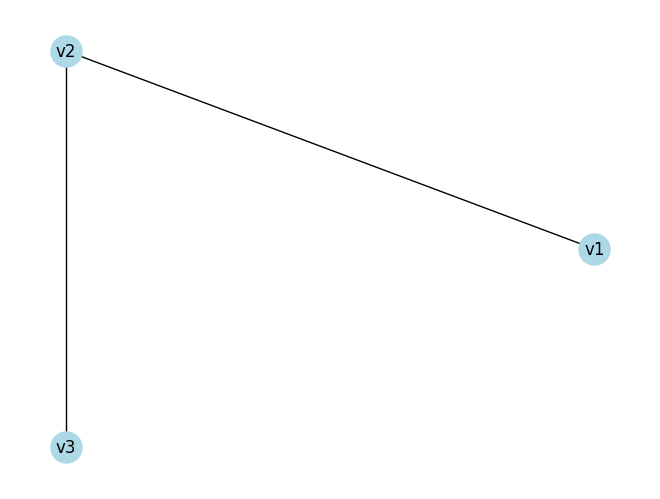

In [231]:
graph = nx.Graph()

vertices_list = ['v1', 'v2', 'v3']
edges_list = [('v1', 'v2'), ('v2', 'v3')]

# vertices_list = ['v1', 'v2', 'v3', 'v4', 'v5']
# edges_list = [
#     ('v1', 'v2'),
#     ('v1', 'v3'),
#     ('v1', 'v5'),
#     ('v2', 'v3'),
#     ('v3', 'v4'),
#     ('v4', 'v5'),
# ]

num_vertices = len(vertices_list)
num_edges = len(edges_list)

graph.add_nodes_from(vertices_list)
graph.add_edges_from(edges_list)

pos = nx.circular_layout(graph)
nx.draw(graph, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=12)

In [241]:
# f(xk, xp) = 1 => a aresta (vk, vp) pertence ao corte
def f(xk: bool, xp: bool) -> bool:
    return (xk and (not xp) ) or ((not xk) and xp)

# g(xk, xp) = 1 => a aresta (vk, vp) não pertence ao corte
def g(xk: bool, xp: bool) -> bool:
    return ((not xk) and (not xp) ) or (xk and xp)

# função auxiliar para geração de um corte aleatório
def random_cut(n: int) -> list:
    rcut = [random.randint(0,1) for _ in range(n)]
    return rcut

def print_matrix(z: list) -> None:
    disp.display(disp.Math(f"z="+sp.latex(sp.Matrix(z))))

def cut_z(dic_v: dict, edge: Tuple, x: list, n: int, m: int) -> list:
    z = [[0 for _ in range(m+1)] for _ in range(m+1)]
    vk = edge[0]
    vp = edge[1]

    k = dic_v[vk]
    p = dic_v[vp]

    edge_cut = f(x[k], x[p])
    no_cut_edge = g(x[k], x[p])

    z[1][1] = int(edge_cut)
    z[1][0] = int(no_cut_edge)

    for i in range(1, m):
        for j in range(i, 0, -1):
            z[i+1][j+1] = int(edge_cut and z[i][j])
            z[i+1][j] = int(no_cut_edge and z[i][j])

    return z

def partition_from_cut(x: List[int]) -> Tuple[List[str], List[str]]:
    V1 = []
    V2 = []
    n = len(x)
    for idx, xi in enumerate(x):
        if xi == 1:
            V1.append(f"v{n-idx}")
        else:
            V2.append(f"v{n-idx}")
    return V1, V2

def print_cut(vertices: list, edges: list, x: List) -> None:
    p1, p2 = partition_from_cut(x)
    V1 = sp.FiniteSet(*p1)
    V2 = sp.FiniteSet(*p2)

    xs = ''.join([f'x_{{{i}}}' for i in range(len(x), 0, -1)])

    latex_strx = f"x={xs}="+ sp.latex(sp.Tuple(*x))
    latex_strv = r"V_1 = " + sp.latex(V1) + r", V_2 = " + sp.latex(V2)
    
    disp.display(disp.Math(latex_strx))
    disp.display(disp.Math(latex_strv))

    sorted_v = natsorted(vertices, reverse=True)
    dic_v = {v: i for i, v in enumerate(sorted_v)}

    cut_size = 0
    for edge in edges:
        z = cut_z(dic_v, edge, x, n, m)
        cut_size += z[m][m]
        z = sp.Matrix(z)
        latex_strz = r"z_{"+sp.latex(sp.Tuple(*edge))+r"}=" + sp.latex(z)

        disp.display(disp.Math(latex_strz))
    print("cut size=", cut_size)

In [233]:
cut_list = [random_cut(num_vertices) for _ in range(5)]

for x in cut_list:
    print_cut(vertices_list, edges_list, x)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

cut size= 0


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

cut size= 1


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

cut size= 1


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

cut size= 2


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

cut size= 0


### Circuito para o corte máximo

1. inicialização do circuito

$$
\ket{\varphi_0} = \bigotimes_{d=n}^1 \ket{x_d^0} = \ket{x^0_n\dotso x^0_2x^0_1} = \ket{\underbrace{0\dotso00}_{n\text{ termos}}}
$$

2. aplicação do operador de Hadamard

$$
\ket{\varphi_1}H^{\otimes^n}\ket{\varphi_0} = \frac{\bigotimes_{d=n}^1 (\ket{x_d^0} + \ket{x_d^1})}{\sqrt{2^n}} = \sum_{x=0}^{2^n-1}\frac{\ket{x}}{\sqrt{2^n}}.
$$

Considerações:

1. O estado $\ket{x^0_n\dotso x_1^0}$ em $\ket{\varphi_1}$ codifica a partição de $n$ vértices dos conjuntos $V_1 = \emptyset$ e $V_2=\{v_n, \dotso, v_1\}$.
2. O estado $\ket{x^0_n\dotso x^0_2x_1^1}$ em $\ket{\varphi_1}$ codifica a partição de $n$ vértices dos conjuntos $V_1 = \{v_1\}$ e $V_2=\{v_n, \dotso,v_2\}$.


### Determinando o conjunto do córte para as arestas

Para determinar a qual parte do corte a aresta pertence, introduzimos qubits auxiliares

$$
\ket{r_{j,s}}, 1\leq j\leq \frac{m(m+1)}{2}, 1\leq s\leq 4
$$

Esses qubits auxiliares tem o propósito de armazenar resultados das operações:

- $x_k\wedge \overline{x_p}$
- $\overline{x_k}\wedge x_p$
- $\overline{x_k}\wedge \overline{x_p}$
- $x_k\wedge x_p$

Além desses qubits precisamos de outros qubits auxiliares

$$
\ket{s_{j,1}}, \ket{s_{j,2}}, 1 \leq j \leq \frac{m(m+1)}{2}
$$

que são inicializados com o valor $1$ e que serão utilizados para avaliar as expressões:

- $\ket{r_{j, 1}} \vee \ket{r_{j, 2}}$
- $\ket{r_{j, 3}} \vee \ket{r_{j, 4}}$

In [275]:
'''
Create the quantum circuit for the example
'''

range_z = int((((num_edges + 1) * (num_edges + 2)) / 2) - 1)
range_r = int(4 * (num_edges * (num_edges + 1)) / 2)
range_s = int(2 * (num_edges * (num_edges + 1)) / 2)

aux = QuantumRegister(1, 'aux')

x_reg = QuantumRegister(num_vertices, 'x')
r_reg = QuantumRegister(range_r, 'r')
s_reg = QuantumRegister(range_s, 's')

z_reg = QuantumRegister(range_z, 'z')
readout = ClassicalRegister(num_vertices, 'out')

qc = QuantumCircuit(aux, x_reg, r_reg, s_reg, z_reg, readout, name="max_cut")

qc.x(aux)
qc.h(aux)

'''
Initialize the system and set it in a uniform superpostion   -> lines 1 and 2 of Algorithm 1 in paper
'''

for qubit in s_reg:
    qc.x(qubit)

for qubit in x_reg:
    qc.h(qubit)
    
qc.barrier()

print(num_vertices, range_r, range_s, range_z)

3 12 6 5


In [276]:
'''
Create z_matrix to store elements of z_reg
'''

z_matrix = [ [ 0 for i in range(num_edges + 1) ] for j in range(num_edges + 1) ]
zij = 0
for i in range(1, num_edges + 1):
    for j in range(i + 1):
        z_matrix[i][j] = zij
        zij += 1

print_matrix(z_matrix)

<IPython.core.display.Math object>

In [277]:
'''
Define the CFE subcircuit
'''

sq = QuantumRegister(10,'sq')
sc = QuantumCircuit(sq, name='CFE')

# EIIAC
sc.x(sq[1])
sc.ccx(sq[0], sq[1], sq[2])
sc.x(sq[0])
sc.x(sq[1])
sc.ccx(sq[0], sq[1], sq[3])
sc.x(sq[0])
sc.x(sq[2])
sc.x(sq[3])
sc.ccx(sq[2], sq[3], sq[6])
sc.x(sq[2])
sc.x(sq[3])

# EINIAC
sc.x(sq[0])
sc.x(sq[1])
sc.ccx(sq[0], sq[1], sq[4])
sc.x(sq[0])
sc.x(sq[1])
sc.ccx(sq[0], sq[1], sq[5])
sc.x(sq[4])
sc.x(sq[5])
sc.ccx(sq[4], sq[5], sq[7])
sc.x(sq[4])
sc.x(sq[5])

# CNOTS
sc.cx(sq[6], sq[9])
sc.cx(sq[7], sq[8])
    
cfe = sc.to_instruction()

In [278]:
'''
Define the CSE subcircuit
'''

cq = QuantumRegister(11,'cq')     
ce = QuantumCircuit(cq, name='CSE')

# EIIAC
ce.x(cq[1])
ce.ccx(cq[0], cq[1], cq[2])
ce.x(cq[0])
ce.x(cq[1])
ce.ccx(cq[0], cq[1], cq[3])
ce.x(cq[0])
ce.x(cq[2])
ce.x(cq[3])
ce.ccx(cq[2], cq[3], cq[6])
ce.x(cq[2])
ce.x(cq[3])

# EINIAC
ce.x(cq[0])
ce.x(cq[1])
ce.ccx(cq[0], cq[1], cq[4])
ce.x(cq[0])
ce.x(cq[1])
ce.ccx(cq[0], cq[1], cq[5])
ce.x(cq[4])
ce.x(cq[5])
ce.ccx(cq[4], cq[5], cq[7])
ce.x(cq[4])
ce.x(cq[5])

# CNOTS
ce.ccx(cq[6], cq[8], cq[9])
ce.ccx(cq[7], cq[8], cq[10])

cse = ce.to_instruction()

In [279]:
qc.draw()

┌───┐┌───┐ ░ 
  aux: ┤ X ├┤ H ├─░─
       ├───┤└───┘ ░ 
  x_0: ┤ H ├──────░─
       ├───┤      ░ 
  x_1: ┤ H ├──────░─
       ├───┤      ░ 
  x_2: ┤ H ├──────░─
       └───┘      ░ 
  r_0: ───────────░─
                  ░ 
  r_1: ───────────░─
                  ░ 
  r_2: ───────────░─
                  ░ 
  r_3: ───────────░─
                  ░ 
  r_4: ───────────░─
                  ░ 
  r_5: ───────────░─
                  ░ 
  r_6: ───────────░─
                  ░ 
  r_7: ───────────░─
                  ░ 
  r_8: ───────────░─
                  ░ 
  r_9: ───────────░─
                  ░ 
 r_10: ───────────░─
                  ░ 
 r_11: ───────────░─
       ┌───┐      ░ 
  s_0: ┤ X ├──────░─
       ├───┤      ░ 
  s_1: ┤ X ├──────░─
       ├───┤      ░ 
  s_2: ┤ X ├──────░─
       ├───┤      ░ 
  s_3: ┤ X ├──────░─
       ├───┤      ░ 
  s_4: ┤ X ├──────░─
       ├───┤      ░ 
  s_5: ┤ X ├──────░─
       └───┘      ░ 
  z_0: ───────────░─
                  ░ 
  z_1: ───────────░─
                  ░ 
  z_2: ───────────░─
                  ░ 
  z_3: ───────────░─
                  ░ 
  z_4: ───────────░─
                  ░ 
out: 3/═════════════

## Referências

- [Quantum Speedup for the Maximum Cut Problem](https://arxiv.org/pdf/2305.16644)
